# 內容說明
#### 這篇作業主要針對劉瓊如老師在語意分析內容中的實作。
#### 其中內容除了針對文本的NLP斷詞分析外，也透過觀察文本的方式萃取特徵以"量化"的角度與斷詞結果進行比較二分類問題。

#### 下列為本篇使用的模型以及模型搭配的分析方式

>RNN：NLP斷詞分析。

>naive_bayes：NLP斷詞分析、文本萃取特徵量化

>Decision Tree：NLP斷詞分析、文本萃取特徵量化


# 資料匯入與基本檢視

In [1]:
import pandas as pd
movie_df = pd.read_csv('yahoo_movie_reviews.txt', sep='\t')
movie_df

,user_name,publish_time,comment,movies_key,movie_name,review_score
0,西瓜,2018-08-29 21:45:59,看完之後好難過😫也感到在浪費時間因為結局讓人好難過,0,復仇者聯盟：無限之戰,4.6
1,Innocent Eyes,2018-08-26 21:44:34,Marvel近期較差的片。大混戰處理得沒味道,0,復仇者聯盟：無限之戰,4.6
2,宏,2018-08-18 02:49:33,5顆星給在特效做得很棒，雖然有些地方還蠻瞎的,0,復仇者聯盟：無限之戰,4.6
3,品,2018-08-12 12:44:34,感覺不合邏輯!奇異博士為什麼要把時間寶石給他呀！一直把他困在時間迴圈裡不就得了嗎？結局 wh...,0,復仇者聯盟：無限之戰,4.6
4,隆,2018-08-12 00:57:40,有人說『對故事線不了解的無法體會情境』，我想我對於復仇者系列不是很瞭解，所以常常會出戲，感覺...,0,復仇者聯盟：無限之戰,4.6
...,...,...,...,...,...,...
7242,Chen,2018-02-28 14:17:03,我覺得普普通通，可以等待二輪片在看,49,犬之島,4.3
7243,柏樹,2018-02-28 14:05:32,真的很好看！結局出乎意料！女主角演技大耀進！,49,犬之島,4.3
7244,橘子,2018-02-28 13:06:57,個人覺得這部片的劇情很緊湊 給人緊張、刺激的興奮感但缺點是整體節奏有點快（根本是本人太慢速了...,49,犬之島,4.3
7245,阿豪,2018-02-28 12:11:23,真的超超超級好看超級大推 完全熱血 刺激 無冷場,49,犬之島,4.3


In [2]:
# movie_df.info()
movie_df.iloc[:3, 2:4]

,comment,movies_key
0,看完之後好難過😫也感到在浪費時間因為結局讓人好難過,0
1,Marvel近期較差的片。大混戰處理得沒味道,0
2,5顆星給在特效做得很棒，雖然有些地方還蠻瞎的,0


In [3]:
movie_types = list(set(movie_df['movie_name']))
num_movies = len(movie_types)
movie_types

['媽媽咪呀！回來了',
 '蟻人與黃蜂女',
 '格雷的五十道陰影：自由',
 '角頭2：王者再起',
 '超人特攻隊2',
 '一級玩家',
 '紅雀',
 '決勝女王',
 '溫徹斯特鬼屋',
 '疾速救援',
 '大師兄',
 '意外',
 '郵報:密戰',
 '私刑教育2',
 '小偷家族',
 '名偵探柯南:零的執行人',
 '毀滅大作戰',
 '星際大戰外傳:韓索羅',
 '宿怨',
 '不可能的任務：全面瓦解',
 '縮小人生',
 '摯友維尼',
 '水底情深',
 '真心話大冒險',
 '鬥魚',
 '犬之島',
 '黑豹',
 '摩天大樓',
 '瞞天過海:八面玲瓏',
 '12猛漢',
 '冠軍大叔',
 '復仇者聯盟：無限之戰',
 '巨齒鯊',
 '瘋狂亞洲富豪',
 '玩命颶風',
 '閨蜜 2',
 '移動迷宮：死亡解藥',
 '環太平洋2: 起義時刻',
 '花甲大人轉男孩',
 '粽邪',
 '鬼修女',
 '陰兒房第4章：鎖命亡靈',
 '死侍2',
 '古墓奇兵',
 '侏羅紀世界:殞落國度',
 '噤界',
 '貼背戰',
 '遊戲夜殺必死',
 '尖叫旅社3:怪獸假期',
 '與神同行：最終審判']

# 從評論製造特徵

### 我們將從文本中人工的提取一些元素作為判斷電影評論的依據。

####  標點符號：以驚嘆號為例。
    
>假設驚嘆號越多，我們認為這個評論越正面。因此先取出驚嘆號，並計算驚嘆號數量，令為`feat_exclamation`

>NOTE：驚嘆號有分半形和全形，想者都要採用

##### 形容詞：
> 好、太、超、非常
> `feat_adj`

##### 介係詞：
> 因為|所以|只是|雖然|然後|可是
> `feat_conj`

##### 標點符號：以波浪號為例
>根據對評論的觀察，發現波浪號在評論中出現頻繁。因此也將波浪號的出現次數視為一個特徵。
>`feat_tilde`
##### 數字出現次數
> `feat_stats`

##### 評論長度：
> `feat_lenpost`

In [4]:
import re

In [5]:
feat_exclamation = []

for comment in movie_df['comment']:
    exclamation = re.findall(r'!|！', comment)
    len_exclamation = len(exclamation)
    feat_exclamation.append(len_exclamation)



In [6]:
feat_adj = []

for comment in movie_df['comment']:
    adj = re.findall(r'好|太|超|非常', comment)
    len_adj = len(adj)
    feat_adj.append(len_adj)



In [7]:
feat_conj = []

for comment in movie_df['comment']:
    conj = re.findall(r'因為|所以|只是|雖然|然後|可是', comment)
    len_conj = len(conj)
    feat_conj.append(len_conj)



In [8]:
feat_tilde = []

for comment in movie_df['comment']:
    tilde = re.findall(r'~+', comment)
    len_tilde = len(tilde)
    feat_tilde.append(len_tilde)

In [9]:
feat_stats = []

for comment in movie_df['comment']:
    stats = re.findall(r'\d+', comment)
    len_stats = len(stats)
    feat_stats.append(len_stats)

In [10]:
feat_lenpost = []

for comment in movie_df['comment']:
    len_lenpost = len(comment)
    feat_lenpost.append(len_lenpost)


> 將上方生成的特徵匯入 `movie_df` dataframe.



In [11]:
movie_df['exclamation'] = feat_exclamation
movie_df['adj'] = feat_adj
movie_df['conj'] = feat_conj
movie_df['tilde'] = feat_tilde
movie_df['stats'] = feat_stats
movie_df['lenpost'] = feat_lenpost

***
## 模型建立

### 定義標籤：三分類
>由於電影評分的分數為0~5，因此我們將電影評分分為三個類別。分別為正面，中立以及負面

- positive: `review_score` > 4.2 
- negative: `review_score` < 3.7
- neutral: 3.7 >= `review_score` <= 4.2



In [12]:
polarity = []

for score in movie_df['review_score']:
    if score > 4.2:
        polarity.append('positive')
    elif score < 3.7:
        polarity.append('negative')
    else:
        polarity.append('neutral')

movie_df['label_3Types'] = polarity


### 定義標籤：二分類
>以4.25為分界，將電影評分分為二類別。分別為正面以及負面


In [13]:
import numpy as np
movie_df["label_2Types"] = np.where(movie_df["review_score"] > 4.25, 1, 0)

### RNN Model 

### 定義分類模型
>這裡採用RNN model進行二分類的電影評論

###  評論整理
>刪除英文字母、數字以及中文以外的所有符號

In [14]:
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line


In [15]:
movie_df['clean_comment'] = movie_df['comment'].apply(remove_punctuation)

#### 斷詞
>這裡先採用jieba進行斷詞，而如果可以想嘗試中研院CKIP Lab的斷詞系統
https://github.com/ckiplab/ckipnlp


In [16]:
import jieba

In [17]:
movie_df['clean_cut_comment'] = movie_df.clean_comment.apply(jieba.lcut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\hughw\AppData\Local\Temp\jieba.cache
Loading model cost 0.417 seconds.
Prefix dict has been built successfully.



#### Word to Vector
>將截斷的文字轉為詞向量，而這部份利用Word2Vec執行



In [18]:
from gensim.models import Word2Vec

In [19]:
#觀察詞向量長度
movie_df['clean_cut_comment'].str.len().describe()

count    7247.000000
mean       26.035739
std        32.032018
min         0.000000
25%        10.000000
50%        16.000000
75%        29.000000
max       438.000000
Name: clean_cut_comment, dtype: float64

In [20]:
#max_size = 438
MovieComment2Vec = Word2Vec(movie_df['clean_cut_comment'], size = 438, iter = 10, sg = 1, min_count = 1)

+ Word2Vec Syntax
(https://radimrehurek.com/gensim/models/word2vec.html)
```
sg ({0, 1}, optional) 
– Training algorithm: 1 for skip-gram; otherwise CBOW.
```

```
min_count
– the min frequence to employ
```

#### Word Embedding
>根據上方評論詞向量的分配，我們決定選擇$P_{75}=29$ 作為詞向量的選取長度

>因為所有的input必須一樣長，所以句子短於29的都會補0，長於29的會被truncate。


In [21]:
embedding_matrix = MovieComment2Vec.wv.vectors

In [22]:
embedding_matrix.shape
#這個尺寸在建立embedding layer時會用到，所以可以先預備起來

(22221, 438)

***
>建立長度29的零矩陣


>n_row = `len(movie_df['clean_cut_comment'])`，n_col = 29

In [23]:
import numpy as np
CommentVecs = np.zeros([len(movie_df['clean_cut_comment']), 29], dtype = "float64")

In [24]:
for i in range(len(movie_df['clean_cut_comment'])):
    for j in range(min(len(movie_df.clean_cut_comment[i]), 29)):
        CommentVecs[i, j] = MovieComment2Vec.wv.vocab[movie_df['clean_cut_comment'][i][j]].index

In [25]:
CommentVecs.shape

(7247, 29)

### 準備標籤
>在上方`定義標籤`的部分已經先以評分"5"作為正面負面臨界值。

In [26]:
label_2Types = movie_df['label_2Types']

### 切割訓練集資料以及測試集資料

In [27]:
from sklearn.model_selection import train_test_split
CommentVecs_train, CommentVecs_test, label_2_train, label_2_test = train_test_split(CommentVecs, label_2Types, train_size = 0.8, random_state = 0)

### 建立模型：二分類

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

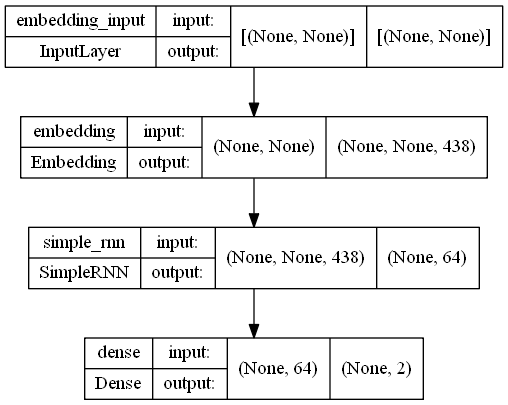

In [29]:
#step 1
RNN = keras.Sequential(name = "RNN")

#step 2
#加入embedding，尺寸參見`embedding_matrix.shape`
RNN.add(layers.Embedding(len(MovieComment2Vec.wv.vectors), 438))

#step 3
RNN.add(layers.SimpleRNN(64))

#Step 4
#layers.Dense(2)：二分類，最後一層
#因為最後一層，所以要用分類器softmax
RNN.add(layers.Dense(2, activation = "softmax"))

keras.utils.plot_model(RNN, show_shapes = True)

In [30]:
#檢視變數數量
RNN.summary()


Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 438)         9732798   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                32192     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 9,765,120
Trainable params: 9,765,120
Non-trainable params: 0
_________________________________________________________________


In [31]:
#由於import layer 不訓練，因此要調整modelweight
RNN.layers[0].set_weights([embedding_matrix])
RNN.layers[0].trainable = False
RNN.summary()

#RNN network completed

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 438)         9732798   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                32192     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 9,765,120
Trainable params: 32,322
Non-trainable params: 9,732,798
_________________________________________________________________


In [32]:
RNN.compile(optimizer = "Adam", 
            loss = keras.losses.sparse_categorical_crossentropy,
            metrics = ["accuracy"])

### 訓練模型

In [33]:
RNN.fit(CommentVecs_train, label_2_train, epochs = 20)

#epochs：訓練次數，資源問題先20次就好

Epoch 1/20
182/182 [==============================] - 1s 4ms/step - loss: 0.7025 - accuracy: 0.5053
Epoch 2/20
182/182 [==============================] - 1s 4ms/step - loss: 0.6940 - accuracy: 0.5225
Epoch 3/20
182/182 [==============================] - 1s 3ms/step - loss: 0.6874 - accuracy: 0.5391
Epoch 4/20
182/182 [==============================] - 1s 3ms/step - loss: 0.6789 - accuracy: 0.5442
Epoch 5/20
182/182 [==============================] - 1s 3ms/step - loss: 0.6708 - accuracy: 0.5648
Epoch 6/20
182/182 [==============================] - 1s 3ms/step - loss: 0.6658 - accuracy: 0.5622
Epoch 7/20
182/182 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.5717
Epoch 8/20
182/182 [==============================] - 1s 3ms/step - loss: 0.6439 - accuracy: 0.5910
Epoch 9/20
182/182 [==============================] - 1s 3ms/step - loss: 0.6307 - accuracy: 0.6024
Epoch 10/20
182/182 [==============================] - 1s 3ms/step - loss: 0.6184 - accuracy: 0.6214

***
## Naive Bayes Model
***
### NLP斷詞分析
>先建立 naive bayes model 的架構，並同時訓練模型



In [34]:
from sklearn.naive_bayes import MultinomialNB

nb_model_NLP = MultinomialNB()
nb_model_NLP.fit(CommentVecs_train, label_2_train)

MultinomialNB()

### Model Prediction

>預測模型

In [35]:
predicted_nb_NLP = nb_model_NLP.predict(CommentVecs_test)

### Model Evaluation
>將上方預測模型的結果進行模型的評估



In [36]:
from sklearn.metrics import accuracy_score

accuracy_score(label_2_test, predicted_nb_NLP)

0.5013793103448276

>在下方建立Confusion Matrix呈現在測試集中的表現


[[352 398]
 [325 375]]


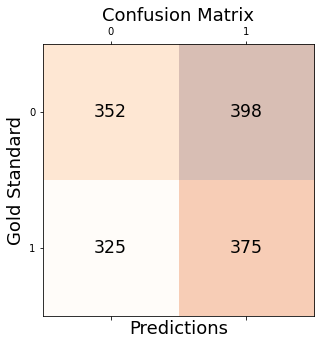

In [37]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(label_2_test, predicted_nb_NLP)
print(conf_matrix)

# print the confusion matrix into a graph

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Gold Standard', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### 文本萃取特徵量化

#### 選取量化特徵，並劃分訓練及與測試集

In [38]:
all_features = movie_df[['exclamation', 'adj', 'conj', 'tilde', 'stats','lenpost']]

feat_train, feat_test, label_2_train, label_2_test = train_test_split(all_features, label_2Types, train_size = 0.8, random_state = 0)

In [39]:
nb_model = MultinomialNB()
nb_model.fit(feat_train, label_2_train) 

MultinomialNB()

In [40]:
predicted_nb = nb_model.predict(feat_test)
accuracy_score(label_2_test, predicted_nb)

0.5048275862068966

>兩者結果差異不大

[[551 199]
 [519 181]]


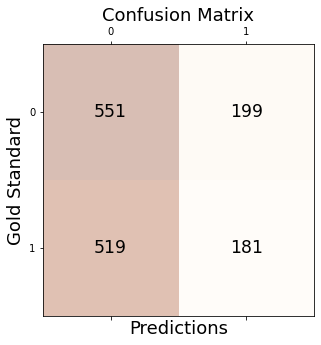

In [41]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(label_2_test, predicted_nb)
print(conf_matrix)

# print the confusion matrix into a graph

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Gold Standard', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

***
## Decision Tree Model Model
***
### NLP斷詞分析

In [42]:
# train a decision tree (DT) model

from sklearn import tree

dt_NLP_model = tree.DecisionTreeClassifier()
dt_NLP_model.fit(CommentVecs_train, label_2_train)


DecisionTreeClassifier()

In [43]:
# train a maximum entropy (MaxEnt) model

from sklearn.linear_model import LogisticRegression
maxent_NLP_model = LogisticRegression(max_iter=500)
maxent_NLP_model.fit(CommentVecs_train, label_2_train)

LogisticRegression(max_iter=500)

> 預測及評估上方兩個模型


In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


# dt_model prediction and evaluation

predicted_dt_NLP = dt_NLP_model.predict(CommentVecs_test)
dt_NLP_accuracy = accuracy_score(label_2_test, predicted_dt_NLP)
dt_NLP_fscore = f1_score(label_2_test, predicted_dt_NLP, average='micro') 
report_dt_NLP = classification_report(label_2_test, predicted_dt_NLP)

# maxent_model prediciton and evaluation

predicted_maxent_NLP = maxent_NLP_model.predict(CommentVecs_test)
maxent_NLP_accuracy = accuracy_score(label_2_test, predicted_maxent_NLP)
maxent_NLP_fscore = f1_score(label_2_test, predicted_maxent_NLP, average='micro') 
report_maxent_NLP= classification_report(label_2_test, predicted_maxent_NLP)

In [45]:
print(dt_NLP_fscore)
print(maxent_NLP_fscore)

0.6572413793103449
0.5151724137931034


> 這兩個模型的結果比RNN和Naive Bayes Model還好

***
### 文本萃取特徵量化
***

In [46]:
# train a decision tree (DT) model

from sklearn import tree

dt_model = tree.DecisionTreeClassifier()
dt_model.fit(feat_train, label_2_train)

# train a maximum entropy (MaxEnt) model

from sklearn.linear_model import LogisticRegression
maxent_model = LogisticRegression(max_iter=500)
maxent_model.fit(feat_train, label_2_train)

LogisticRegression(max_iter=500)

In [47]:
# dt_model prediction and evaluation

predicted_dt = dt_model.predict(feat_test)
dt_accuracy = accuracy_score(label_2_test, predicted_dt)
dt_fscore = f1_score(label_2_test, predicted_dt, average='micro') 
report_dt = classification_report(label_2_test, predicted_dt)

# maxent_model prediciton and evaluation

predicted_maxent = maxent_model.predict(feat_test)
maxent_accuracy = accuracy_score(label_2_test, predicted_maxent)
maxent_fscore = f1_score(label_2_test, predicted_maxent, average='micro') 
report_maxent= classification_report(label_2_test, predicted_maxent)

In [48]:
print(dt_fscore)
print(maxent_fscore)

0.5062068965517241
0.5110344827586207
